<h1>
<center>CFRM 421/521</center>
</h1>

<h1>
<center>[Insert your name here]</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Tuesday, April 15, 2025, 11:59 PM**


* Total marks: 49


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [10 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

Next, we create stratified test and training sets based on different income categories.

In [71]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split_obj = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_obj.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index] 

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [72]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [73]:
X_raw.shape

(16512, 9)

In [74]:
X_raw[X_raw.isnull().any(axis=1)].shape

(168, 9)

In [75]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.

**Solution:**

In [76]:
imputer_med = SimpleImputer(strategy='median')
X_num = X_raw.select_dtypes(include=[np.number])
X = pd.DataFrame(
    data=imputer_med.fit_transform(X_num),
    columns = X_num.columns,
    index=X_num.index)

In [77]:
# check that null rows are gone
X[X.isnull().any(axis=1)].shape

(0, 8)

## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**Solution:**

It's not appropriate to use the `OrdinalEncoder`in this scenario because ML algorithms will assume that nearby values are more similar than distant values. This is of course not the case for the different values of the `ocean_proximity` column

In [78]:
OrdinalEncoder().fit_transform(X_raw[['ocean_proximity']])[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [79]:
X_raw[['ocean_proximity']].head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [80]:
cat_encoder = OneHotEncoder()
cat_encoder.fit(X_raw[['ocean_proximity']])
X_cat = pd.DataFrame(
    data=cat_encoder.transform(X_raw[['ocean_proximity']]).toarray(),
    columns=cat_encoder.get_feature_names_out(),
    index=X_raw.index)

## (c) Feature engineering [2 marks]

Often it may be useful to experiment with transforming and combining features to create new features that may be expected to better predict the target variable. Features that are skewed or heavily tailed can be logged to make them closer to normal. An example of a feature combination is instead of using the number of bedrooms, which may not be meaningful by itself, we should consider the number of bedrooms relative to the number of rooms.

**Task:** Read the subsections "Custom Transformers" and "Transformation Pipelines" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.FunctionTransformer` class take the log of `population`, and to create the ratio `total_bedrooms/total_rooms`. Print these two transformed features.

**Solution:**

In [ ]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
ratio_transformer = FunctionTransformer(lambda x: x.iloc[:, 0] / x.iloc[:, 1])

In [82]:
# log of population
log_transformer.transform(X_raw['population'])

13096    7.362645
14973    6.501290
3785     6.331502
14689    7.520235
20507    7.555905
           ...   
14207    6.843750
13105    7.257708
19301    7.942362
19121    7.452982
19888    6.525030
Name: population, Length: 16512, dtype: float64

In [83]:
# ratio of total bedrooms and total rooms
ratio_transformer.transform(X_raw[['total_bedrooms', 'total_rooms']])

13096    0.335742
14973    0.180153
3785     0.200369
14689    0.203881
20507    0.277371
           ...   
14207    0.266875
13105    0.201019
19301    0.197704
19121    0.230891
19888    0.452436
Length: 16512, dtype: float64

## (d) Feature scaling and transformation [1 mark]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have a similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1, here we focus on the latter.

**Task:** Read the subsection "Feature Scaling and Transformation" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.StandardScaler` class to scale the numerical features using standardization. 

**Solution:**

In [ ]:
std_scaler = StandardScaler()
std_scaler.fit_transform(X_num)

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]], shape=(16512, 8))

## (e) Transformation pipelines [4 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `ColumnTransformer` and `Pipeline` classes provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then create one pipeline that combines the above steps  in the following way applied to the original "raw" features `X_raw`: part (a) (a median imputer for numerical features), part (c) (create the ratios `total_bedrooms/total_rooms`, `total_rooms/households`, `population/households`; and take the log of `total_bedrooms`, `total_rooms`, `population`, `households`, `median_income`), part (d) (a standard scaler for all numerical features, including the transformed features), part (b) (one-hot encoding for categorical variables). Call your transformed features `X`, and print it.

**Solution:**

In [85]:
X_raw.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [ ]:
"""
3 types of pipelines:
    - longtitude, latitude, housing_median_age: median, standard scaler
    - total_rooms, total_bedrooms, population, households, median_income: median, log, standard scaler
    - bedrooms/rooms, rooms/households, populatio/households: ratio, median standard scaler
    - ocean_proximity: one hot
"""

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
)
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(func=np.log, feature_names_out='one-to-one'),
    StandardScaler(),
)

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

ratio_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(lambda x: x[:, [0]] / x[:, [1]], feature_names_out=ratio_name),
    StandardScaler(),
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'),
)

preproc = ColumnTransformer([
    ('bedrooms', ratio_pipeline, ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline, ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline, ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
],
remainder=default_num_pipeline)

X = preproc.fit_transform(X_raw)
X = pd.DataFrame(
    data=X,
    columns=preproc.get_feature_names_out(),
    index=X_raw.index,
)
X.sample(10)

KeyboardInterrupt: 

# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(e) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**Solution:**

In [ ]:
lin_reg = make_pipeline(preproc, LinearRegression())
lin_reg.fit(X_raw, y)

Y_hat = lin_reg.predict(X_raw)
Y_hat[:10]

array([260051.36004114, 357897.79846769, 125817.08984353, 110019.21093156,
       298948.54915206, 206437.53193813, 306787.013961  , 326902.92850959,
       162297.74181859,  68786.66157655])

## (b) RMSE and MAE  [2 marks]

We can measure the performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**Solution:**

In [ ]:
print(mean_absolute_error(y_true=y, y_pred=Y_hat))
print(mean_squared_error(y_true=y, y_pred=Y_hat))
print(root_mean_squared_error(y_true=y, y_pred=Y_hat))

53034.28396497742
4988628216.224896
70630.22169174394


## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**Solution:**

In [ ]:
lin_reg_rmse = -cross_val_score(
    lin_reg, X_raw, y,
    scoring='neg_root_mean_squared_error', cv=10)
print(pd.Series(lin_reg_rmse, name='RMSE'))
print(f'\nMean RMSE: {np.mean(lin_reg_rmse)}')

0    72183.905515
1    69449.072331
2    68141.823309
3    82334.167571
4    70196.458235
5    70974.121152
6    70512.169101
7    73270.782301
8    69384.522316
9    71459.775911
Name: RMSE, dtype: float64

Mean RMSE: 71790.67977414606


## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [ ]:
dt_reg = make_pipeline(preproc, DecisionTreeRegressor(random_state=42))
dt_reg.fit(X_raw,y)
Y_hat_dt = dt_reg.predict(X_raw)

The following code does the same for the random forest model.

In [ ]:

rf_reg = make_pipeline(
    preproc,
    RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
)
rf_reg.fit(X_raw, y)

Y_hat_rf = rf_reg.predict(X_raw)

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**Solution:**

In [ ]:
dt_reg_rmse = -cross_val_score(
    dt_reg, X_raw, y,
    scoring='neg_root_mean_squared_error', cv=10)
rf_reg_rmse = -cross_val_score(
    rf_reg, X_raw, y,
    scoring='neg_root_mean_squared_error', cv=10)

print(f'In-sample RMSE linear regression: {root_mean_squared_error(y_true=y, y_pred=Y_hat)}')
print(f'In-sample RMSE decision tree: {root_mean_squared_error(y_true=y, y_pred=Y_hat_dt)}')
print(f'In-sample RMSE random forest: {root_mean_squared_error(y_true=y, y_pred=Y_hat_rf)}')
print(f'Out-of-sample RMSE linear regression: {np.mean(lin_reg_rmse)}')
print(f'Out-of-sample RMSE decision tree: {np.mean(dt_reg_rmse)}')
print(f'Out-of-sample RMSE random forest: {np.mean(rf_reg_rmse)}')


In-sample RMSE linear regression: 70630.22169174394
In-sample RMSE decision tree: 0.0
In-sample RMSE random forest: 62145.4331743811
Out-of-sample RMSE linear regression: 71790.67977414606
Out-of-sample RMSE decision tree: 70042.97685272685
Out-of-sample RMSE random forest: 63718.42510089457


The decision tree has the best in sample performance, but this is due to the model badly overfitting the data. This is seen because of the huge difference between the in-sample (IS) and out-of-sample (OOS) RMSE for the model. Random forest has the smallest OOS RMSE, and it's pretty close to the IS value. The linear regression does not overfit the data (IS and OOS RMSE are similar) but performs worse than both decision tree and random foreset OOS.

## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has hyperparameter including `n_estimators` and `max_features`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `max_features` over the values 4, 6, 8, 10 and `n_estimators` over the values 10, 50, 100. Use 3-fold cross-validation with RMSE when searching for the best hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search with 10 iterations, where  `max_features` is a uniform random integer between 2 and 20 and `n_estimators` is a uniform random integer between 10 and 200. `RandomizedSearchCV` must include the argument `random_state=42`.


In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**Solution:**

In [ ]:
rf_pipeline = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(random_state=42))
])

params = [{
    'rf__max_features': [4, 6, 8, 10],
    'rf__n_estimators': [10, 50, 200],
}]

grid_search = GridSearchCV(
    rf_pipeline,
    params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)
grid_search.fit(X_raw, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<functio...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7c5805896840>)])),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'rf__max_features': [4, 6, 8, 10],
                          'rf__n_estimators': [10, 50, 200]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
print(grid_search.best_params_)

{'rf__max_features': 6, 'rf__n_estimators': 200}


In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values('mean_test_score', ascending=False).head(5).T

,5,8,2,11,4
mean_fit_time,13.507848,17.535628,9.764302,19.700695,3.478575
std_fit_time,0.04313,0.071419,0.195565,2.57919,0.055375
mean_score_time,0.281243,0.267162,0.317231,0.262271,0.095826
std_score_time,0.008565,0.001887,0.017011,0.014947,0.011265
param_rf__max_features,6,8,4,10,6
param_rf__n_estimators,200,200,200,200,50
params,"{'rf__max_features': 6, 'rf__n_estimators': 200}","{'rf__max_features': 8, 'rf__n_estimators': 200}","{'rf__max_features': 4, 'rf__n_estimators': 200}","{'rf__max_features': 10, 'rf__n_estimators': 200}","{'rf__max_features': 6, 'rf__n_estimators': 50}"
split0_test_score,-48991.914585,-49051.174247,-49254.560006,-49574.362847,-49763.320362
split1_test_score,-49113.281519,-49414.807273,-49207.903569,-49759.4544,-49676.023491
split2_test_score,-49865.595333,-50201.135979,-50325.707038,-50394.134449,-50571.933608


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_pipeline = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(random_state=42))
])

params_rand = [{
    'rf__max_features': randint(low=2, high=20),
    'rf__n_estimators': randint(low=10, high=200),
}]

rand_search = RandomizedSearchCV(
    rf_pipeline,
    params_rand,
    cv=3,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)
rand_search.fit(X_raw, y)

KeyboardInterrupt: 

In [ ]:
print(rand_search.best_params_)

{'rf__max_features': 7, 'rf__n_estimators': 139}


In [ ]:
rs_res = pd.DataFrame(rand_search.cv_results_)
rs_res.sort_values('mean_test_score', ascending=False).head(5).T

,9,5,0,6,2
mean_fit_time,10.095353,6.617576,16.95847,7.539493,19.500817
std_fit_time,1.478797,0.03884,0.226884,0.092742,0.254798
mean_score_time,0.200898,0.175836,0.267455,0.225161,0.400441
std_score_time,0.007994,0.025196,0.012323,0.011243,0.182073
param_rf__max_features,7,5,8,4,9
param_rf__n_estimators,139,113,189,159,198
params,"{'rf__max_features': 7, 'rf__n_estimators': 139}","{'rf__max_features': 5, 'rf__n_estimators': 113}","{'rf__max_features': 8, 'rf__n_estimators': 189}","{'rf__max_features': 4, 'rf__n_estimators': 159}","{'rf__max_features': 9, 'rf__n_estimators': 198}"
split0_test_score,-48830.91508,-49150.940346,-49064.631818,-49350.895156,-49169.801054
split1_test_score,-49127.535853,-49241.197209,-49403.668877,-49168.975618,-49459.924557
split2_test_score,-49875.237378,-50025.584545,-50204.985003,-50339.40269,-50320.941193


The RMSE is the smallest for parameters `max_features=7` and `n_estimators=139`. 

## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**Solution:**

In [ ]:
# pull out the final model, look at the importance of features
final_model = rand_search.best_estimator_
sorted(zip(
    final_model['rf'].feature_importances_,
    final_model['preproc'].get_feature_names_out()),
    reverse=True
)

[(np.float64(0.35394835025287724), 'log__median_income'),
 (np.float64(0.15669337316155735), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.11096059905850102), 'people_per_house__ratio'),
 (np.float64(0.0750608988111958), 'remainder__longitude'),
 (np.float64(0.06744296822738217), 'remainder__latitude'),
 (np.float64(0.057969636734118535), 'rooms_per_house__ratio'),
 (np.float64(0.05741092640423246), 'bedrooms__ratio'),
 (np.float64(0.04179742669263859), 'remainder__housing_median_age'),
 (np.float64(0.016224643536551366), 'log__total_rooms'),
 (np.float64(0.01590251372289503), 'log__population'),
 (np.float64(0.015527294637388262), 'log__total_bedrooms'),
 (np.float64(0.014287298611809347), 'log__households'),
 (np.float64(0.009952541897254221), 'cat__ocean_proximity_<1H OCEAN'),
 (np.float64(0.004253069588605567), 'cat__ocean_proximity_NEAR OCEAN'),
 (np.float64(0.0023904824430666717), 'cat__ocean_proximity_NEAR BAY'),
 (np.float64(0.0001779762199264849), 'cat__ocean_proximity_ISLAND

In [ ]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

final_pred = final_model.predict(X_test)

print(root_mean_squared_error(y_true=y_test, y_pred=final_pred))

49016.24364007325


# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**Solution:**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# add polynomial features
poly_feat = PolynomialFeatures(degree=3, include_bias=False)
poly_reg = make_pipeline(preproc, poly_feat, LinearRegression())
poly_reg.fit(X_raw, y)
Y_hat_poly = poly_reg.predict(X_raw)
print(root_mean_squared_error(y_true=y, y_pred=Y_hat_poly))



50465.323420855064


In [ ]:
from sklearn.linear_model import Ridge

# add polynomial features
poly_feat = PolynomialFeatures(degree=3, include_bias=False)
ridge_reg = make_pipeline(preproc, poly_feat, Ridge(alpha=1, solver='cholesky'))
ridge_reg.fit(X_raw, y)
Y_hat_ridge = ridge_reg.predict(X_raw)
print(root_mean_squared_error(y_true=y, y_pred=Y_hat_ridge))

51786.17870574128


## (b) Learning curves [4 marks]

Obtain learning curves using the function `sklearn.model_selection.learning_curve` to plot the learning curve with 5-fold CV for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither.

**Solution:**

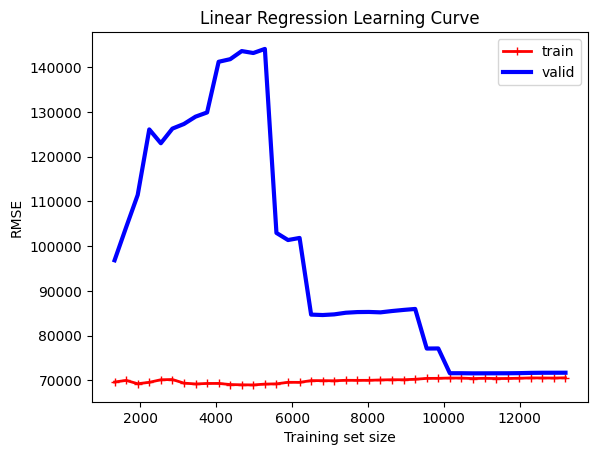

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    lin_reg, X_raw, y, train_sizes=np.linspace(0.1, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.title('Linear Regression Learning Curve')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Training set size')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    poly_reg, X_raw, y, train_sizes=np.linspace(0.1, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.title('Polynomial Regression Learning Curve')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Training set size')
plt.show()

KeyboardInterrupt: 

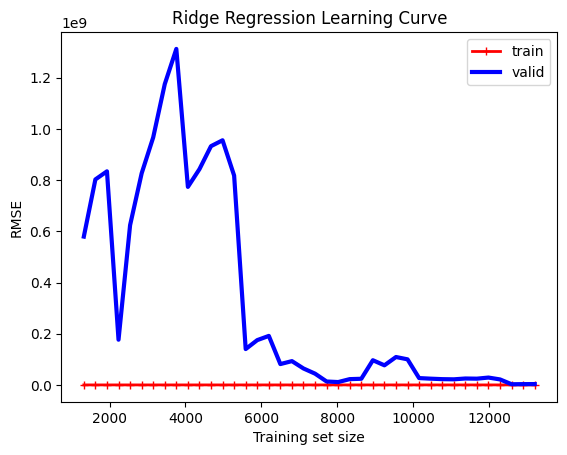

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    ridge_reg, X_raw, y, train_sizes=np.linspace(0.1, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.title('Ridge Regression Learning Curve')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Training set size')
plt.show()

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/104571273/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then use `sklearn.model_selection.train_test_split` to split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

**Solution:**

In [4]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("datasets/default.csv")

X_train, X_test, Y_train, Y_test = train_test_split(
    data[['student', 'balance', 'income']],
    data[['default']],
    test_size=0.2, random_state=42)

## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**Solution:**

In [5]:
X_train.isna().any()

student    False
balance    False
income     False
dtype: bool

In [6]:
num_pipeline_default = make_pipeline(
    StandardScaler(),
)
cat_pipeline_default = make_pipeline(
    OneHotEncoder(drop='if_binary'),
)

preproc_default = ColumnTransformer([
    ('cat', cat_pipeline_default, make_column_selector(dtype_include=object)),
    ('num', num_pipeline_default, make_column_selector(dtype_include=np.number))
],
remainder=num_pipeline_default)

# process the X training data
X_proc = preproc_default.fit_transform(X_train)
X_proc = pd.DataFrame(
    data=X_proc,
    columns=preproc_default.get_feature_names_out(),
    index=X_train.index,
)
print(X_proc.sample(5))

# process the Y training data
Y_proc = preproc_default.fit_transform(Y_train)
Y_proc = pd.DataFrame(
    data=Y_proc.toarray(),
    columns=preproc_default.get_feature_names_out(),
    index=Y_train.index,
).squeeze()
print(Y_proc.sample(5))

      cat__student_Yes  num__balance  num__income
1925               0.0     -0.656366     1.307398
6637               0.0      0.285216    -0.551949
1694               1.0      1.130950    -1.351241
1187               1.0      0.127131    -0.734248
9946               1.0     -0.204977    -1.196513
3809    0.0
4370    0.0
6383    0.0
7545    0.0
8300    0.0
Name: cat__default_Yes, dtype: float64


## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC. Use the default arguments, except you must include the argument `random_state=42`.  Furthermore, for the logistic regression, compute the ROC AUC for `C` taking the values 0.001, 0.01, 0.1, 1, 10, 100, to show that the default value of 1 is approximately optimal.

**Solution:**

In [22]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_predict

y_scores_sgd = cross_val_predict(
    SGDClassifier(random_state=42), X_proc, Y_proc,
    cv=10, method='decision_function')

y_scores_lin = cross_val_predict(
    LogisticRegression(), X_proc, Y_proc,
    cv=10, method='decision_function')

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(Y_proc, y_scores_sgd)

recalls_sgd = tpr_sgd
fpr_lin, tpr_lin, thresholds_lin = roc_curve(Y_proc, y_scores_lin)

SGD ROC AUC: 0.9389439574128043


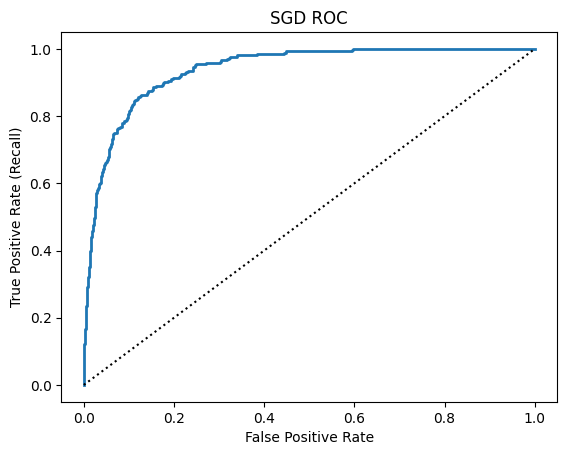

In [25]:
plt.plot(fpr_sgd, tpr_sgd, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
# [...] # beautify the figure: add labels, grid, legend, arrow, and text
plt.title('SGD ROC')
print(f'SGD ROC AUC: {roc_auc_score(Y_proc, y_scores_sgd)}')
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()

Logistic ROC AUC: 0.9501425840619222


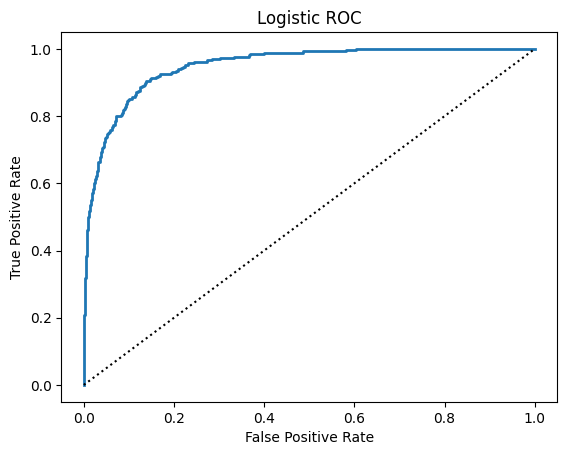

In [26]:
plt.plot(fpr_lin, tpr_lin, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
# [...] # beautify the figure: add labels, grid, legend, arrow, and text
plt.title('Logistic ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

print(f'Logistic ROC AUC: {roc_auc_score(Y_proc, y_scores_lin)}')
plt.show()

In [27]:
for c in [0.001, 0.01, 0.1, 1, 10, 100]:
    y_scores_lin_temp = cross_val_predict(
        LogisticRegression(C=c), X_proc, Y_proc,
        cv=10,)
    print(f'Logistic ROC AUC C={c}: {roc_auc_score(Y_proc, y_scores_lin_temp)}')


Logistic ROC AUC C=0.001: 0.5
Logistic ROC AUC C=0.01: 0.5244919463507882
Logistic ROC AUC C=0.1: 0.6444760427438815
Logistic ROC AUC C=1: 0.6647276801103067
Logistic ROC AUC C=10: 0.6666216195042463
Logistic ROC AUC C=100: 0.6666216195042463


## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 75%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve a 75% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**Solution:**

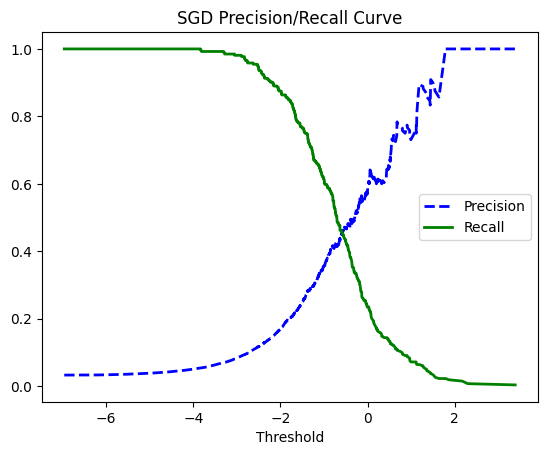

In [15]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(Y_proc, y_scores_sgd)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.title('SGD Precision/Recall Curve')
plt.xlabel('Threshold')
plt.legend()
plt.show()

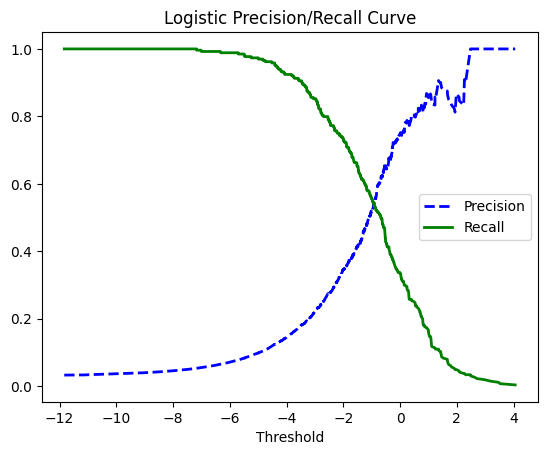

In [16]:
precisions, recalls, thresholds = precision_recall_curve(Y_proc, y_scores_lin)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.title('Logistic Precision/Recall Curve')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [43]:
y_scores = pd.DataFrame()
y_scores.loc[:, 'sgd'] = cross_val_predict(
    SGDClassifier(random_state=42), X_proc, Y_proc,
    cv=10, method='decision_function')

y_scores.loc[:, 'log'] = cross_val_predict(
    LogisticRegression(), X_proc, Y_proc,
    cv=10, method='decision_function')

y_scores.loc[:, 'sgd_bal'] = cross_val_predict(
    SGDClassifier(random_state=42, class_weight='balanced'), X_proc, Y_proc,
    cv=10, method='decision_function')

y_scores.loc[:, 'log_bal'] = cross_val_predict(
    LogisticRegression(class_weight='balanced'), X_proc, Y_proc,
    cv=10, method='decision_function')

precisions = pd.DataFrame()
recalls = pd.DataFrame()
thresholds = pd.DataFrame()
tgt_threshold = 0.75
for model in ['sgd', 'log', 'sgd_bal', 'log_bal']:
    precisions.loc[:, model], recalls.loc[:, model], thresholds.loc[:, model] = precision_recall_curve(Y_proc, y_scores[model])
    ix = (recalls[model] >= tgt_threshold).idxmin()
    print(f'Model {model} {tgt_threshold: .2%} recall yields precision of {precisions.loc[ix, model]: .2%}')

Model sgd  75.00% recall yields precision of  27.86%
Model log  75.00% recall yields precision of  32.19%
Model sgd_bal  75.00% recall yields precision of  23.76%
Model log_bal  75.00% recall yields precision of  32.03%


The logistic regression with default parameters yields the best precision of 32.19%

## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**Solution:**

In [51]:
# the best classifier is the logistic regression

# first preprocess the test data

# process the X training data
X_proc_test = preproc_default.fit_transform(X_test)
X_proc_test = pd.DataFrame(
    data=X_proc_test,
    columns=preproc_default.get_feature_names_out(),
    index=X_test.index,
)
print(X_proc_test.sample(5))

# process the Y training data
Y_proc_test = preproc_default.fit_transform(Y_test)
Y_proc_test = pd.DataFrame(
    data=Y_proc_test.toarray(),
    columns=preproc_default.get_feature_names_out(),
    index=Y_test.index,
).squeeze()
print(Y_proc_test.sample(5))

log_model = LogisticRegression()
log_model.fit(X_proc, Y_proc)
Y_test_pred = log_model.predict(X_proc_test)
Y_test_scores = log_model.decision_function(X_proc_test)

      cat__student_Yes  num__balance  num__income
3412               0.0     -0.244790     0.773636
668                0.0      0.159742     0.874820
8897               1.0      0.990363    -1.272364
500                1.0      0.258779    -1.263864
1617               0.0     -0.168564     0.883360
6478    0.0
1245    0.0
4856    0.0
5466    0.0
6100    0.0
Name: cat__default_Yes, dtype: float64


In [49]:
precision_score(Y_proc_test, Y_test_pred)

0.6333333333333333

In [50]:
recall_score(Y_proc_test, Y_test_pred)

0.2753623188405797

In [54]:
fpr_test, tpr_test, thresholds_test = roc_curve(Y_proc_test, Y_test_scores)

Best classifier (Logistic) test ROC AUC: 0.9435300475086124


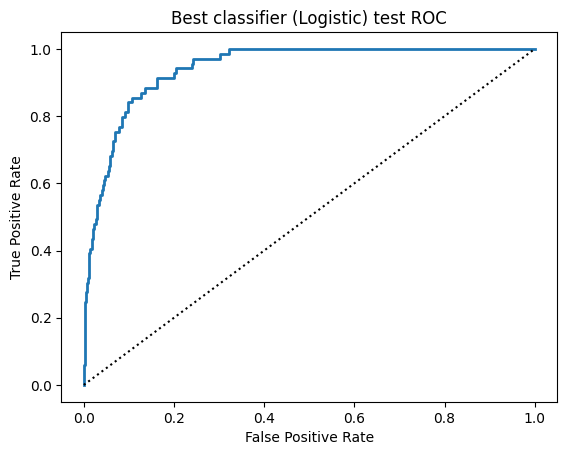

In [57]:
plt.plot(fpr_test, tpr_test, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
# [...] # beautify the figure: add labels, grid, legend, arrow, and text
plt.title('Best classifier (Logistic) test ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

print(f'Best classifier (Logistic) test ROC AUC: {roc_auc_score(Y_proc_test, Y_test_scores)}')
plt.show()